In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Defining libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os
import pickle
import random
import glob

import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
# The data sets recorded on the PC are read.
with open('/content/drive/MyDrive/global_ai/project_2/info/train.pickle','rb') as handle:
    train_data = pickle.load(handle)
with open('/content/drive/MyDrive/global_ai/project_2/info/test.pickle','rb') as handle:
    test_data = pickle.load(handle)
with open('/content/drive/MyDrive/global_ai/project_2/info/val.pickle','rb') as handle:
    val_data = pickle.load(handle)
len(train_data),len(test_data),len(val_data)

(19956, 2495, 2495)

In [5]:
# The generator function has been enhanced. In each epoch, Batch feeds the model with data of its size. 
# It prevents the model from being overfitted by performing data augmentation only for the training dataset.
def generator_data(ar_data,batch_size,_train=False):
  def generator(ar_data):
    while True:
      for i in ar_data:
        yield i
  
  data = generator(ar_data)

  while True:
    input = []; output = []
    for i in range(0,batch_size):
      iteration = next(data)
      image = iteration[0]
      label = iteration[1]
      
      if _train == True:
        image = np.expand_dims(image,axis=0)
        datagen = ImageDataGenerator(width_shift_range=0.08, height_shift_range=0.08, rotation_range=10, brightness_range=(0.5,1.0))
        aug_iter = datagen.flow(image,batch_size=1)
        image = next(aug_iter)[0].astype("float32") /255
      else:
        pass
      
      input.append(image)
      output.append(label)
      
    yield (np.array(input) , np.array(output))

In [6]:
# Batch size is determined and processed in generator function of datasets.
batch_size = 32
train_set = generator_data(train_data,batch_size,_train=1)
test_set = generator_data(test_data,batch_size)
val_set = generator_data(val_data,batch_size)

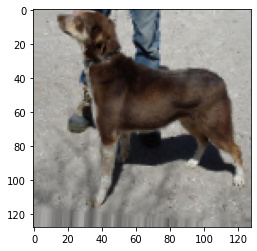

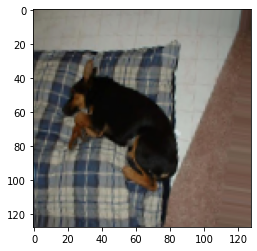

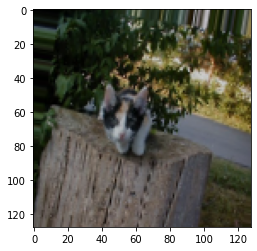

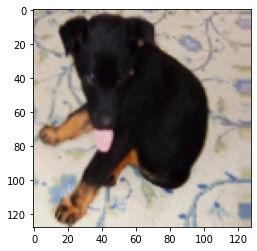

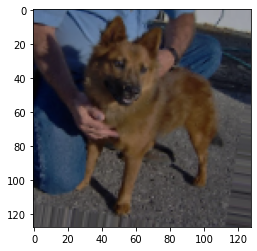

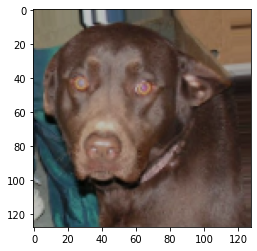

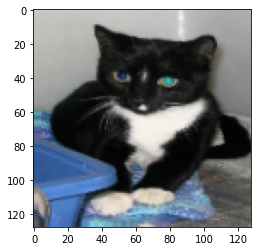

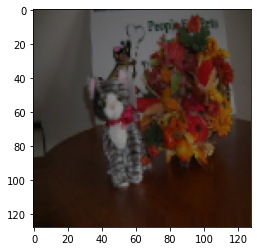

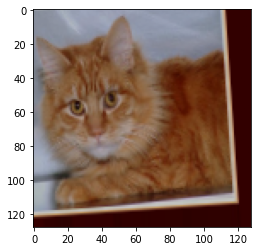

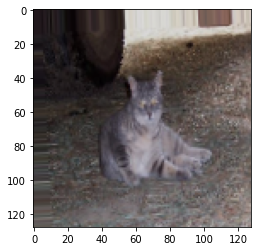

In [7]:
# It is the control of the images up to the batch size of the images in the Train dataset.
deneme = next(train_set)
deneme[0].shape
for idx,i in enumerate(deneme[0]):
  if idx == 10: break
  plt.imshow(i[:,:,::-1])
  plt.show()

In [8]:
# Defining deep learning models in Tensorflow
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121

In [9]:
# Added denses, dropout and pooling layers to the VGG16 model.
_VGG16 = VGG16(weights="imagenet",include_top=False, input_shape=(128,128,3))
for _layers in _VGG16.layers:
    _layers.trainable=False
x = layers.Dense(256, activation="relu")(_VGG16.output)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation="sigmoid")(x)
VGG16 = tf.keras.Model(_VGG16.input, x)
VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [10]:
# It is the code snippet to register the best model according to val_acc.
checkpoint_path = "../MyDrive/global_ai/project_2/models"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1,monitor='val_accuracy', save_best_only=True)

In [11]:
# Our model is compiled according to Adam optimizer function, BinaryCrossentropy loss function and accuracy metric.
# And our model is trained with the datasets we prepared.
VGG16.compile(optimizer='adam',
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 10

history = VGG16.fit(train_set, steps_per_epoch = len(train_data)//batch_size, 
                                       epochs = epochs, validation_data = val_set, 
                                       validation_steps = len(val_data)//batch_size, shuffle=1, callbacks = [cp_callback])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


623/623 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.8154
Epoch 1: val_accuracy improved from -inf to 0.88271, saving model to ../MyDrive/global_ai/project_2/models
623/623 [==============================] - 119s 170ms/step - loss: 0.3955 - accuracy: 0.8154 - val_loss: 0.2754 - val_accuracy: 0.8827
Epoch 2/10
623/623 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8581
Epoch 2: val_accuracy did not improve from 0.88271
623/623 [==============================] - 103s 165ms/step - loss: 0.3198 - accuracy: 0.8581 - val_loss: 0.3120 - val_accuracy: 0.8701
Epoch 3/10
623/623 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8729
Epoch 3: val_accuracy did not improve from 0.88271
623/623 [==============================] - 102s 164ms/step - loss: 0.2900 - accuracy: 0.8729 - val_loss: 0.2844 - val_accuracy: 0.8782
Epoch 4/10
623/623 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8793
Epoch 4: val_

In [13]:
# The trained model is tested with the test data set.
VGG16.evaluate(test_set,steps=len(test_data)//batch_size)

77/77 [==============================] - 4s 56ms/step - loss: 0.2060 - accuracy: 0.9221


[0.2060149610042572, 0.9220778942108154]

In [18]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


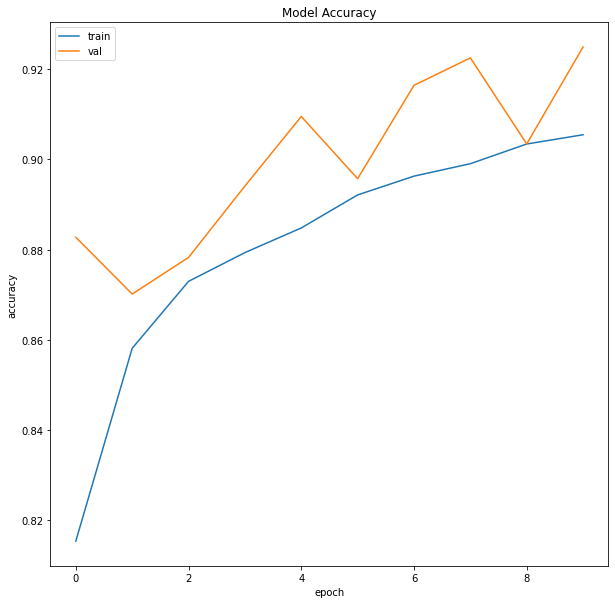

In [19]:
# The accuracy graph is to show the train adn val accuracy at each epoch.
# As can be seen, there was no overfitting or underfitting.
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')

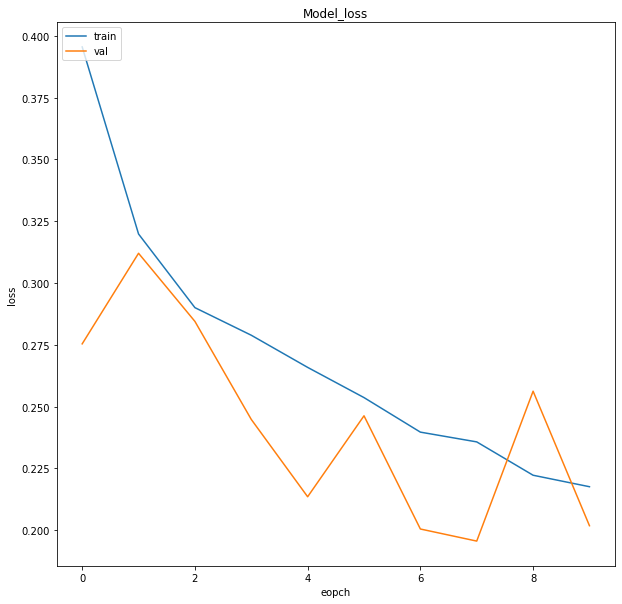

In [21]:
# The loss graph is to show the train and val loss at each epoch.
# As can be seen, the train and val loss values are close to each other and there is no excessive deviation.
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('eopch')
plt.legend(['train','val'],loc='upper left')